In [1]:
from SimPEG import *
from simpegEM1D import *
from scipy.constants import mu_0
import numpy as np
frequency = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
hz = get_vertical_discretization_frequency(frequency, sigma_background=0.01)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

FDsurvey = EM1DSurveyFD(
    rx_location = np.array([0., 0., 100.+30.]),
    src_location = np.array([0., 0., 100.+30.]),
    field_type = 'secondary',
    rx_type = 'ppm',
    src_type = 'VMD',
    offset = np.ones(5)*7.86,
    topo = np.r_[0., 0., 100.],
    depth = depth,
    frequency = frequency
)

sig_half = 1e-3
sig_blk = sig_half*50.
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)
sig  = np.ones(FDsurvey.n_layer)*sig_half
blk_ind = (-50>LocSigZ) & (-80<LocSigZ)
sig[blk_ind] = sig_blk
# sig[-150>LocSigZ] = 0.1
m_true = np.r_[np.log(sig)]

In [2]:
prob = EM1D(
    mesh1D, sigmaMap=expmap,
    chi= np.zeros(FDsurvey.n_layer),
    verbose=False
)
if prob.ispaired:
    prob.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob.pair(FDsurvey)     
d_true = FDsurvey.dpred(m_true)
m0 = np.ones_like(m_true) * np.log(sig_half)
d_0 = FDsurvey.dpred(m0)

In [3]:
FDsurvey.dtrue = d_true
std = 0.05
floor = 0.
np.random.seed(1)
uncert = std*abs(FDsurvey.dtrue)+floor
noise = std*FDsurvey.dtrue*np.random.randn(FDsurvey.dtrue.size)
FDsurvey.dobs = FDsurvey.dtrue+noise
doi, _=prob.depth_of_investigation(uncert)
delta = prob.get_threshold(uncert)

In [4]:
print (doi, delta)

172.35910288100044 0.015955794996744738


In [5]:
from SimPEG import Regularization

In [6]:

dmisfit = DataMisfit.l2_DataMisfit(FDsurvey)
dmisfit.W = 1./(abs(FDsurvey.dobs)*std+floor)

reg = Regularization.Sparse(
    mesh1D, mapping=Maps.IdentityMap(mesh1D)
)
p=0.
qx, qz = 2., 2.
reg.norms = np.c_[p, qx, qz, 0.]
IRLS = Directives.Update_IRLS(
    maxIRLSiter=20, minGNiter=1, fix_Jmatrix=True, coolingRate=2, 
    betaSearch=False,
    chifact_start = 1.
)
opt = Optimization.ProjectedGNCG(maxIter = 40)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
sense = Directives.UpdateSensitivityWeights(threshold=delta)
# inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
inv = Inversion.BaseInversion(invProb, directiveList=[IRLS, betaest])

prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.70e+01  8.42e+02  0.00e+00  8.42e+02    6.45e+01      0              


/Users/sgkang/Projects/simpeg/SimPEG/Directives.py:885: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.UpdatePreconditioner` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


   1  8.52e+00  6.82e+02  2.87e+00  7.07e+02    5.77e+01      0              
   2  4.26e+00  4.02e+02  1.43e+01  4.63e+02    1.03e+02      0              
   3  2.13e+00  8.57e+01  4.38e+01  1.79e+02    2.72e+02      0              
   4  1.06e+00  1.68e+01  3.70e+01  5.61e+01    1.94e+01      0              
   5  5.32e-01  1.17e+01  3.52e+01  3.05e+01    3.56e+01      1   Skip BFGS  
   6  2.66e-01  9.29e+00  3.46e+01  1.85e+01    4.70e+01      1   Skip BFGS  
   7  1.33e-01  7.45e+00  3.37e+01  1.19e+01    4.41e+01      1   Skip BFGS  
   8  6.65e-02  5.29e+00  3.37e+01  7.53e+00    5.66e+00      0   Skip BFGS  
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 4.619386775262308 eps_q: 4.619386775262308
>> Fix Jmatrix
Eps_p: 3.849488979385257
Eps_q: 3.849488979385257
delta phim:    inf
   9  3.33e-02  4.54e+00  4.84e+01  6.15e+00    2.79e+01      1   Skip BFGS  
>> Fix Jmatrix
Eps_p: 3.2079074828210477
Eps_q: 3.2079074828210477
delta phim: 7.441e-01
 

In [7]:
doi, act_ind = prob.depth_of_investigation(uncert)

In [8]:
print (doi)

230.0630993146064


Populating the interactive namespace from numpy and matplotlib


/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta', 'floor', 'inv', 'pi', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


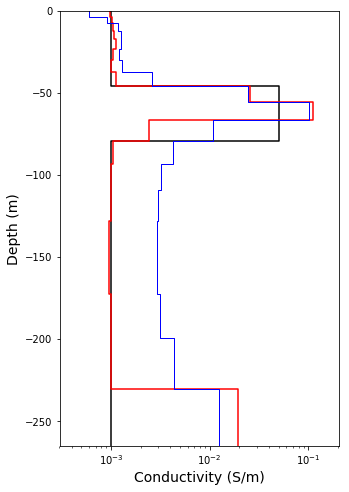

In [9]:
%pylab inline
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=False)
Utils1D.plotLayer(expmap*mopt, mesh1D, showlayers=False, **{'color':'r'})
Utils1D.plotLayer(expmap*invProb.l2model, mesh1D, showlayers=False, **{'color':'b', 'lw':1})

In [10]:
print (doi)

230.0630993146064


In [11]:
delta = prob.get_threshold(uncert)

In [12]:
print (delta)

0.0037711442200994323


In [13]:
# !python run_em1d.py

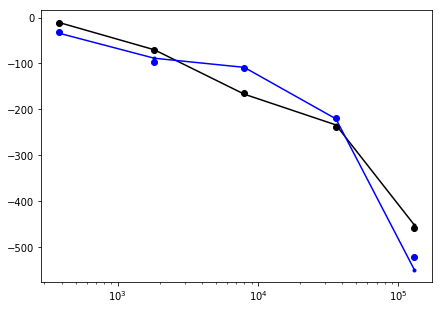

In [14]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(FDsurvey.frequency, -invProb.dpred[0:FDsurvey.n_frequency], 'k.-')
axes.plot(FDsurvey.frequency, -invProb.dpred[FDsurvey.n_frequency:], 'b.-')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[0:FDsurvey.n_frequency], 'ko')
axes.plot(FDsurvey.frequency, -FDsurvey.dobs[FDsurvey.n_frequency:], 'bo')
# axes.plot(FDsurvey.frequency, uncert[0:FDsurvey.n_frequency], 'k*')
# axes.plot(FDsurvey.frequency, uncert[FDsurvey.n_frequency:], 'r*')
axes.set_xscale('log')

In [15]:
from scipy.linalg.blas import cgemm
import numpy as np

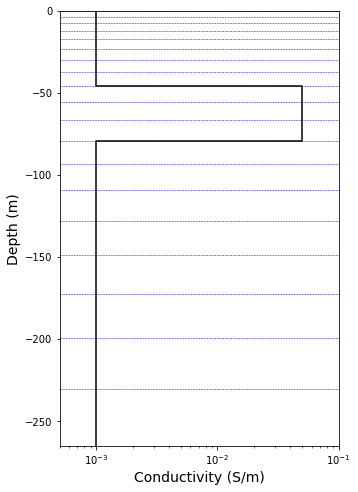

In [16]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, mesh1D, showlayers=True)